In [1]:
%%bash
pip install gensim
pip install emoji --no-deps


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


## Import Libraries

In [2]:
import re
import string
import emoji
import pandas as pd
import nltk

from bs4 import BeautifulSoup

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import pandas as pd
from sklearn.utils import resample
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, precision_recall_curve
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn import svm
import pickle
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer
from torch.nn.utils.rnn import pad_sequence
import torch
from transformers import BertModel, BertTokenizer
import gc
from transformers import (
    BertTokenizer, BertModel,
    RobertaTokenizer, RobertaModel,
    DistilBertTokenizer, DistilBertModel
)

from sklearn.model_selection import train_test_split
import re
import os
import requests
import gc
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sarfrazahmad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sarfrazahmad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sarfrazahmad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Read Data

In [3]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
train_path = os.path.join(BASE_DIR, 'Dataset', 'english_dataset', 'english_dataset.tsv')
test_path = os.path.join(BASE_DIR, 'Dataset', 'english_dataset', 'hasoc2019_en_test-2919.tsv')

In [4]:
train = pd.read_csv(train_path, sep='\t')
test = pd.read_csv(test_path, sep='\t')

train.drop(["text_id", 'task_2', 'task_3'], axis=1, inplace=True)
test.drop(["text_id", 'task_2', 'task_3'], axis=1, inplace=True)

# rename task_1 to label
train.rename(columns={'task_1': 'label'}, inplace=True)
test.rename(columns={'task_1': 'label'}, inplace=True)

# Map the labels to integers
label_map = {'HOF': 1, 'NOT': 0}

train['label'] = train['label'].map(label_map)
test['label'] = test['label'].map(label_map)

In [5]:
train.shape, test.shape

((5852, 2), (1153, 2))

## Data Pre-processing

In [5]:
# Data Cleaning

# Contraction Mapping: Map commonly used contractions to their expanded forms
# This helps normalize text and makes it easier to process later.
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", 
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", 
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
                       "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", 
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                       "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", 
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", 
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                       "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                       "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", 
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", 
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'u.s':'america', 'e.g':'for example'}

# Punctuation List: Common punctuation symbols to identify and process in text
punct = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

# Punctuation Mapping: Map specific punctuation to replacements for normalization
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-",
                 "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 
                 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '!':' '}

# Misspelling Dictionary: Map common misspellings to their correct spellings
mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ',
                'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can',
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 
                'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 
                'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization',
                'demonetisation': 'demonetization'}

In [6]:
def clean_text(text):
    '''Clean emoji, Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''

    # Remove User Mentions
    text = re.sub(r'@\w+\s*', '', text)

    # Remove Hashtags
    text = re.sub(r'#\w+', '', text)

    # Convert emojis to demojized text if emojis exist
    if any(char in emoji.EMOJI_DATA for char in text):
        text = emoji.demojize(text)

    # Remove only emoji placeholders (not all colon-enclosed text)
    text = re.sub(r'\:[a-zA-Z0-9_]+\:', '', text)

    text = str(text).lower()    #Making Text Lowercase
    text = re.sub('\[.*?\]', '', text)
    #The next 2 lines remove html text

    text = BeautifulSoup(text, 'lxml').get_text()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "'")
    text = re.sub(r"[^a-zA-Z?.!,¿']+", " ", text)
    return text

def clean_contractions(text, mapping):
    '''Clean contraction using contraction mapping'''    
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    for word in mapping.keys():
        if ""+word+"" in text:
            text = text.replace(""+word+"", ""+mapping[word]+"")
    #Remove Punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    return text

def clean_special_chars(text, punct, mapping):
    '''Cleans special characters present(if any)'''   
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

def correct_spelling(x, dic):
    '''Corrects common spelling errors'''   
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

def remove_space(text):
    '''Removes awkward spaces'''   
    #Removes awkward spaces 
    text = text.strip()
    text = text.split()
    return " ".join(text)

def text_preprocessing_pipeline(text):
    '''Cleaning and parsing the text.'''
    text = clean_text(text)
    text = clean_contractions(text, contraction_mapping)
    text = clean_special_chars(text, punct, punct_mapping)
    text = correct_spelling(text, mispell_dict)
    text = remove_space(text)
    return text

In [7]:
%%time
# Pre-processing
train['text'] = train['text'].apply(text_preprocessing_pipeline)
test['text'] = test['text'].apply(text_preprocessing_pipeline)

CPU times: user 2.97 s, sys: 676 µs, total: 2.97 s
Wall time: 2.97 s


In [8]:
train.head()

,text,label
0,watch sports minister kiren rijiju issues stat...,0
1,no we should remember very clearly that just a...,1
2,guess who would be the winner of this team who...,0
3,corbyn is too politically intellectual for can...,0
4,all the best to for another swimming competiti...,0


In [9]:
test.head()

,text,label
0,west bengal doctor crisis protesting doctors a...,0
1,million people have been forced to leave their...,0
2,you came you saw we will look after the fort g...,0
3,we will get brexit delivered by october help b...,0
4,fuck you go back to the dark ages you cow rape...,1


## LSTM

In [10]:
# Parameters
MAX_LEN = 128
BATCH_SIZE = 32
EPOCHS = 10
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
NUM_CLASSES = 2

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_texts(texts):
    return [torch.tensor(tokenizer.encode(text, truncation=True, max_length=MAX_LEN)) for text in texts]

# Prepare datasets
train_texts, val_texts, train_labels, val_labels = train_test_split(train['text'], train['label'], test_size=0.2, random_state=42, stratify=train['label'])
test_texts, test_labels = test['text'], test['label']

train_tokens = tokenize_texts(train_texts)
val_tokens = tokenize_texts(val_texts)
test_tokens = tokenize_texts(test_texts)

# Label encoding
label_encoder = LabelEncoder()
train_labels = torch.tensor(label_encoder.fit_transform(train_labels))
val_labels = torch.tensor(label_encoder.transform(val_labels))
test_labels = torch.tensor(label_encoder.transform(test_labels))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
# Dataset Class
class TextDataset(Dataset):
    def __init__(self, tokens, labels):
        self.tokens = tokens
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.tokens[idx], self.labels[idx]

# Padding function
def collate_fn(batch):
    tokens, labels = zip(*batch)
    tokens_padded = pad_sequence(tokens, batch_first=True, padding_value=tokenizer.pad_token_id)
    return tokens_padded, torch.tensor(labels)

# DataLoader
train_dataset = TextDataset(train_tokens, train_labels)
val_dataset = TextDataset(val_tokens, val_labels)
test_dataset = TextDataset(test_tokens, test_labels)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [12]:
# LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        output = self.fc(hidden[-1])
        return self.softmax(output)

# Initialize model
VOCAB_SIZE = tokenizer.vocab_size
model = LSTMClassifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [13]:
# Training Loop
def train_epoch(model, data_loader, criterion, optimizer):
    model.train()
    total_loss, total_correct = 0, 0

    for tokens, labels in data_loader:
        optimizer.zero_grad()
        outputs = model(tokens)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (outputs.argmax(1) == labels).sum().item()

    return total_loss / len(data_loader), total_correct / len(train_loader.dataset)

In [14]:
# Evaluation Function
def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss, total_correct = 0, 0
    predictions, true_labels = [], []

    with torch.no_grad():
        for tokens, labels in data_loader:
            outputs = model(tokens)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            total_correct += (outputs.argmax(1) == labels).sum().item()

            predictions.extend(outputs.argmax(1).tolist())
            true_labels.extend(labels.tolist())

    return total_loss / len(data_loader), total_correct / len(data_loader.dataset), predictions, true_labels

In [15]:
# Training loop
for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

Epoch 1/10
Train Loss: 0.6664, Train Accuracy: 0.6174
Val Loss: 0.6681, Val Accuracy: 0.6097
Epoch 2/10
Train Loss: 0.6647, Train Accuracy: 0.6178
Val Loss: 0.6674, Val Accuracy: 0.6106
Epoch 3/10
Train Loss: 0.6615, Train Accuracy: 0.6176
Val Loss: 0.6663, Val Accuracy: 0.6234
Epoch 4/10
Train Loss: 0.6429, Train Accuracy: 0.6554
Val Loss: 0.6618, Val Accuracy: 0.6191
Epoch 5/10
Train Loss: 0.6212, Train Accuracy: 0.6811
Val Loss: 0.6714, Val Accuracy: 0.6132
Epoch 6/10
Train Loss: 0.5807, Train Accuracy: 0.7285
Val Loss: 0.6767, Val Accuracy: 0.6089
Epoch 7/10
Train Loss: 0.5361, Train Accuracy: 0.7718
Val Loss: 0.7127, Val Accuracy: 0.5756
Epoch 8/10
Train Loss: 0.5084, Train Accuracy: 0.8035
Val Loss: 0.6811, Val Accuracy: 0.6208
Epoch 9/10
Train Loss: 0.4751, Train Accuracy: 0.8349
Val Loss: 0.6922, Val Accuracy: 0.6080
Epoch 10/10
Train Loss: 0.4628, Train Accuracy: 0.8502
Val Loss: 0.7011, Val Accuracy: 0.5961


Test Loss: 0.6283, Test Accuracy: 0.6652
              precision    recall  f1-score   support

           0       0.82      0.71      0.76       865
           1       0.38      0.52      0.44       288

    accuracy                           0.67      1153
   macro avg       0.60      0.62      0.60      1153
weighted avg       0.71      0.67      0.68      1153



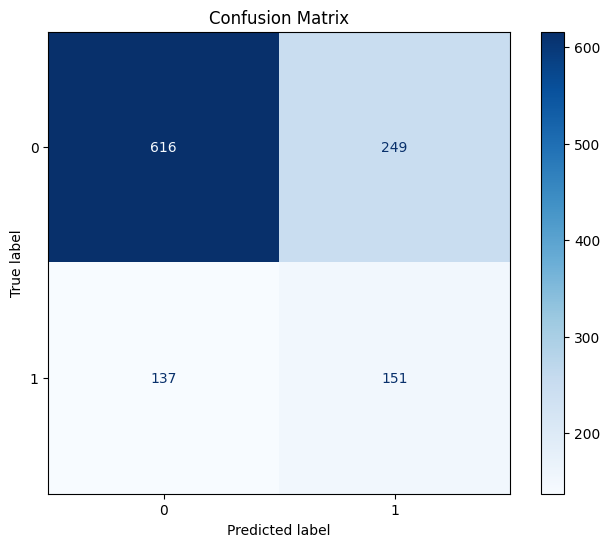

In [16]:
# Test Evaluation
test_loss, test_acc, test_preds, test_true = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Classification Report
class_names = [str(cls) for cls in label_encoder.classes_]  # Convert classes to strings
print(classification_report(test_true, test_preds, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(test_true, test_preds)

# Plot the confusion matrix with blue color
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()

## LLM-Based Approach

### BERT

In [17]:
# Train-Test Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train['text'].tolist(), train['label'].tolist(), test_size=0.2, random_state=42, 
    stratify = train['label']
)

test_texts = test['text'].tolist()
test_labels = test['label'].tolist()

In [ ]:
# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# 4. Custom Dataset Class
class HateSpeechDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = HateSpeechDataset(train_encodings, train_labels)
val_dataset = HateSpeechDataset(val_encodings, val_labels)

# Model Initialization
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to="none"  # Disable W&B
)

# Custom metric function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=1).numpy()
    
    # Compute metrics
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  # Add this line
)

# Training
trainer.train()

# Save Model
model.save_pretrained('./BERT')
tokenizer.save_pretrained('./BERT')

# Evaluation
eval_results = trainer.evaluate()
print(eval_results)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.614700,0.627649,0.668659,0.670213,0.278761,0.393750
2,0.600800,0.603574,0.684885,0.726776,0.294248,0.418898
3,0.491000,0.698582,0.670367,0.617021,0.384956,0.474114


{'eval_loss': 0.6035737991333008, 'eval_accuracy': 0.6848847139197267, 'eval_precision': 0.726775956284153, 'eval_recall': 0.2942477876106195, 'eval_f1': 0.41889763779527567, 'eval_runtime': 4.3923, 'eval_samples_per_second': 266.603, 'eval_steps_per_second': 2.277, 'epoch': 3.0}


Test Results: {'eval_loss': 0.42521578073501587, 'eval_accuracy': 0.8404163052905465, 'eval_precision': 0.8333333333333334, 'eval_recall': 0.4513888888888889, 'eval_f1': 0.5855855855855856, 'eval_runtime': 3.4611, 'eval_samples_per_second': 333.126, 'eval_steps_per_second': 2.889, 'epoch': 3.0}
                 precision    recall  f1-score   support

Non-Hate Speech       0.84      0.97      0.90       865
    Hate Speech       0.83      0.45      0.59       288

       accuracy                           0.84      1153
      macro avg       0.84      0.71      0.74      1153
   weighted avg       0.84      0.84      0.82      1153



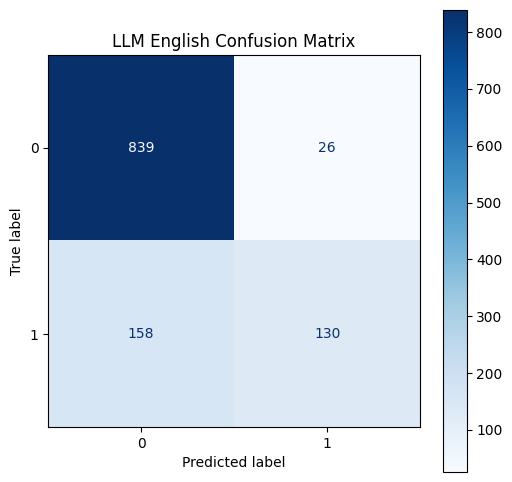

In [19]:
# Tokenize the test data
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# Create a Dataset object for the test data
test_dataset = HateSpeechDataset(test_encodings, test_labels)

# Evaluate the model on the test dataset
test_results = trainer.evaluate(test_dataset)
print("Test Results:", test_results)

# Get predictions for the test dataset
predictions = trainer.predict(test_dataset)

# Extract logits, predictions, and true labels
logits = predictions.predictions
predicted_labels = torch.argmax(torch.tensor(logits), dim=1).numpy()
true_labels = test_labels

# Compute detailed metrics
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_labels, target_names=["Non-Hate Speech", "Hate Speech"]))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix with blue color
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title("LLM English Confusion Matrix")
plt.show()

### DistilBERT

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import torch
from torch.utils.data import Dataset

# Tokenization
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# Custom Dataset Class
class HateSpeechDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = HateSpeechDataset(train_encodings, train_labels)
val_dataset = HateSpeechDataset(val_encodings, val_labels)

# Model Initialization
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to="none"  # Disable W&B
)

# Custom metric function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=1).numpy()
    
    # Compute metrics
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  # Add this line
)

# Training
trainer.train()

# Save Model
model.save_pretrained('./DistilBERT')
tokenizer.save_pretrained('./DistilBERT')

# Evaluation
eval_results = trainer.evaluate()
print(eval_results)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.611300,0.628344,0.664389,0.676647,0.250000,0.365105
2,0.599800,0.603152,0.678053,0.709497,0.280973,0.402536
3,0.510500,0.658972,0.656704,0.570621,0.446903,0.501241


{'eval_loss': 0.6031515002250671, 'eval_accuracy': 0.6780529461998293, 'eval_precision': 0.7094972067039106, 'eval_recall': 0.2809734513274336, 'eval_f1': 0.4025356576862123, 'eval_runtime': 2.4781, 'eval_samples_per_second': 472.543, 'eval_steps_per_second': 4.035, 'epoch': 3.0}


Test Results: {'eval_loss': 0.4419659376144409, 'eval_accuracy': 0.839549002601908, 'eval_precision': 0.7754010695187166, 'eval_recall': 0.5034722222222222, 'eval_f1': 0.6105263157894736, 'eval_runtime': 1.8697, 'eval_samples_per_second': 616.663, 'eval_steps_per_second': 5.348, 'epoch': 3.0}
                 precision    recall  f1-score   support

Non-Hate Speech       0.85      0.95      0.90       865
    Hate Speech       0.78      0.50      0.61       288

       accuracy                           0.84      1153
      macro avg       0.81      0.73      0.75      1153
   weighted avg       0.83      0.84      0.83      1153



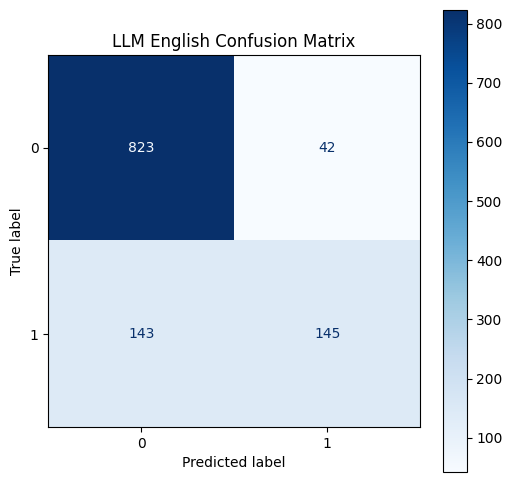

In [21]:
# Tokenize the test data
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# Create a Dataset object for the test data
test_dataset = HateSpeechDataset(test_encodings, test_labels)

# Evaluate the model on the test dataset
test_results = trainer.evaluate(test_dataset)
print("Test Results:", test_results)

# Get predictions for the test dataset
predictions = trainer.predict(test_dataset)

# Extract logits, predictions, and true labels
logits = predictions.predictions
predicted_labels = torch.argmax(torch.tensor(logits), dim=1).numpy()
true_labels = test_labels

# Compute detailed metrics
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_labels, target_names=["Non-Hate Speech", "Hate Speech"]))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix with blue color
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title("LLM English Confusion Matrix")
plt.show()